In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import diffrax
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from exciting_environments.pmsm.pmsm_env import PMSM,step_eps
from functools import partial

2025-02-18 15:19:22.167850: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
import jax_dataclasses as jdc
from models.models import MLP

In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

In [4]:
class ExpertModel(eqx.Module):
    motor_env: PMSM = eqx.field(static=True)
    psi_dq_mlp: MLP

    def __init__(self, motor_env, psi_layer_sizes, key):
        self.motor_env = motor_env
        key, subkey = jax.random.split(key)
        self.psi_dq_mlp = MLP(
            psi_layer_sizes, key=subkey, hidden_activation=jax.nn.swish, output_activation=jax.nn.tanh
        )

    def __call__(self, init_obs, actions, tau):

        def body_fun(carry, action):
            obs = carry
            obs = self.step(obs, action, tau)
            return obs, obs

        _, observations = jax.lax.scan(body_fun, init_obs, actions)
        observations = jnp.concatenate([init_obs[None, :], observations], axis=0)
        return observations

    def step(self, obs, action, tau):
        obs1, _ = self.motor_env.reset(self.motor_env.env_properties)  #
        obs1 = obs1.at[2].set((3 * 1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
        obs1 = obs1.at[0].set(obs[0])
        obs1 = obs1.at[1].set(obs[1])
        obs1 = obs1.at[4].set(obs[2])
        obs1 = obs1.at[5].set(obs[3])
        state = self.motor_env.generate_state_from_observation(obs1, self.motor_env.env_properties)
        # obs,_= self.motor_env.step(state, action, self.motor_env.env_properties)
        obs, _ = self.step_expert(state, action, self.motor_env.env_properties)
        return jnp.concatenate([obs[0:2], obs[4:6]])

    @partial(jax.jit, static_argnums=[0, 3])
    def ode_step(self, state, u_dq, properties):
        """Computes state by simulating one step.

        Args:
            system_state: The state from which to calculate state for the next step.
            u_dq: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """
        system_state = state.physical_state
        omega_el = system_state.omega_el
        i_d = system_state.i_d
        i_q = system_state.i_q
        eps = system_state.epsilon

        args = (u_dq, properties.static_params)
        if properties.saturated:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, _ = args

                J_k = jnp.array([[0, -1], [1, 0]])
                i_dq = jnp.array([i_d, i_q])
                p_d = {q: interp(jnp.array([i_d, i_q])) for q, interp in self.motor_env.LUT_interpolators.items()}
                i_dq_norm = i_dq / properties.physical_constraints.i_d

                p_d["Psi_d"] = self.Psi_d(i_dq_norm)
                p_d["Psi_q"] = self.Psi_q(i_dq_norm)
                p_d["L_dd"] = self.L_dd(i_dq_norm)
                p_d["L_dq"] = self.L_dq(i_dq_norm)
                p_d["L_qd"] = self.L_qd(i_dq_norm)
                p_d["L_qq"] = self.L_qq(i_dq_norm)

                L_diff = jnp.column_stack([p_d[q] for q in ["L_dd", "L_dq", "L_qd", "L_qq"]]).reshape(2, 2)
                L_diff_inv = jnp.linalg.inv(L_diff)
                psi_dq = jnp.column_stack([p_d[psi] for psi in ["Psi_d", "Psi_q"]]).reshape(-1)
                di_dq_1 = jnp.einsum(
                    "ij,j->i",
                    (-L_diff_inv * properties.static_params.r_s),
                    i_dq,
                )
                di_dq_2 = jnp.einsum("ik,k->i", L_diff_inv, u_dq)
                di_dq_3 = jnp.einsum("ij,jk,k->i", -L_diff_inv, J_k, psi_dq) * omega_el
                i_dq_diff = di_dq_1 + di_dq_2 + di_dq_3
                d_y = i_dq_diff[0], i_dq_diff[1]

                return d_y

        else:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, params = args
                u_d = u_dq[0]
                u_q = u_dq[1]
                l_d = params.l_d
                l_q = params.l_q
                psi_p = params.psi_p
                r_s = params.r_s
                i_d_diff = (u_d + omega_el * l_q * i_q - r_s * i_d) / l_d
                i_q_diff = (u_q - omega_el * (l_d * i_d + psi_p) - r_s * i_q) / l_q
                d_y = i_d_diff, i_q_diff
                return d_y

        term = diffrax.ODETerm(vector_field)
        t0 = 0
        t1 = self.motor_env.tau
        y0 = tuple([i_d, i_q])
        env_state = self.motor_env._solver.init(term, t0, t1, y0, args)
        y, _, _, env_state, _ = self.motor_env._solver.step(term, t0, t1, y0, args, env_state, made_jump=False)

        i_d_k1 = y[0]
        i_q_k1 = y[1]

        if properties.saturated:
            torque = jnp.array(
                [self.motor_env.currents_to_torque_saturated(i_d=i_d_k1, i_q=i_q_k1, env_properties=properties)]
            )[0]
        else:
            torque = jnp.array([self.motor_env.currents_to_torque(i_d_k1, i_q_k1, properties)])[0]

        with jdc.copy_and_mutate(system_state, validate=False) as system_state_next:
            system_state_next.epsilon = step_eps(eps, omega_el, self.motor_env.tau, 1.0)
            system_state_next.i_d = i_d_k1
            system_state_next.i_q = i_q_k1
            system_state_next.torque = torque  # [0]

        with jdc.copy_and_mutate(state, validate=False) as state_next:
            state_next.physical_state = system_state_next
        return state_next

    @partial(jax.jit, static_argnums=[0, 3])
    def step_expert(self, state, action, env_properties):
        """Computes state by simulating one step taking the deadtime into account.

        Args:
            system_state: The state from which to calculate state for the next step.
            action: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """

        action = self.motor_env.constraint_denormalization(action, state, env_properties)

        action_buffer = jnp.array([state.physical_state.u_d_buffer, state.physical_state.u_q_buffer])

        if env_properties.static_params.deadtime > 0:

            updated_buffer = jnp.array([action[0], action[1]])
            u_dq = action_buffer
        else:
            updated_buffer = action_buffer

            u_dq = action

        next_state = self.ode_step(state, u_dq, env_properties)
        with jdc.copy_and_mutate(next_state, validate=True) as next_state_update:
            next_state_update.physical_state.u_d_buffer = updated_buffer[0]
            next_state_update.physical_state.u_q_buffer = updated_buffer[1]

        observation = self.motor_env.generate_observation(next_state_update, env_properties)
        return observation, next_state_update

    def Psi_d(self, i_dq_norm):
        return self.psi_dq_mlp(i_dq_norm)[0]  #  self.motor_env.LUT_interpolators["Psi_d"](i_dq)[0]

    def Psi_q(self, i_dq_norm):
        return self.psi_dq_mlp(i_dq_norm)[1]  #   self.motor_env.LUT_interpolators["Psi_q"](i_dq)[0]

    def Psi_d_physical(self, i_dq):
        i_dq_norm = i_dq / self.motor_env.env_properties.physical_constraints.i_d
        return self.Psi_d(i_dq_norm)

    def Psi_q_physical(self, i_dq):
        i_dq_norm = i_dq / self.motor_env.env_properties.physical_constraints.i_d
        return self.Psi_q(i_dq_norm)

    def l_d_dq(self, i_dq):
        return jax.grad(self.Psi_d_physical)(i_dq)

    def l_q_dq(self, i_dq):
        return jax.grad(self.Psi_q_physical)(i_dq)

    def L_dd(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_d_dq(i_dq)[0]

    def L_dq(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_d_dq(i_dq)[1]

    def L_qd(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_q_dq(i_dq)[0]

    def L_qq(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_q_dq(i_dq)[1]

    def L_matrix(self, i_dq):
        L_dd = self.L_dd(i_dq)
        L_dq = self.L_dq(i_dq)
        L_qd = self.L_qd(i_dq)
        L_qq = self.L_qq(i_dq)
        mat = jnp.array([[L_dd, L_dq], [L_qd, L_qq]])
        return mat


In [5]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

Reset function to get random initial_observation for training of the dpc - using pmsm_env reset for random init:

In [6]:
@eqx.filter_jit
def reset(node,rng):
    obs, _ = motor_env.reset(motor_env.env_properties, rng) 
    obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs

Function returns random initial_observation and reference_observation the dpc should target while training:

In [7]:
@eqx.filter_jit
def dat_gen_sin(node, rng, traj_len):
    rng, subkey = jax.random.split(rng)
    ref_obs = reset(node,subkey) 
    rng, subkey = jax.random.split(rng)
    init_obs = reset(node,subkey)  
    return init_obs, ref_obs, rng

Featurize function for the dpc policy - feat_obs is input of the dpc_policy network:

In [8]:
@eqx.filter_jit
def featurize(obs,ref_obs, featurize_state=jnp.array([0,0])):
    feat_obs=jnp.concatenate([obs[0:2],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])
    featurize_state=jnp.clip(featurize_state + ref_obs[0:2]-obs[0:2],min=-1,max=1) * (jnp.sign(0.01-jnp.sum((ref_obs[0:2]-obs[0:2])**2))*0.5+0.5)
    return feat_obs,featurize_state

Loss for reference tracking:

In [9]:
@eqx.filter_jit
def mse_loss(feat_obs):
    loss=jnp.mean(jnp.sum((feat_obs[:,4:6])**2,axis=1))#be aware of idx if changing featurize
    return loss

Soft constraints:

In [10]:
@eqx.filter_jit
def penalty_loss(feat_obs):
    i_d=feat_obs[:,0]*0.5-0.5
    i_q=feat_obs[:,1]
    penalties = jnp.sum(jax.nn.relu(i_d**2+i_q**2-1))
    return penalties

Initialize dpc-policy:

In [11]:
jax_key = jax.random.PRNGKey(2)
policy=MLP([8,64,64,64,2],key=jax_key)
optimizer = optax.adam(5e-4)
opt_state = optimizer.init(policy)

Design training structure:

In [12]:
data_batch_size=100
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=10000,
    horizon_length=20,
    data_gen_sin=dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

In [13]:
def featurize_node(obs):
    return obs[:4]

### 1.Example: DPC Training on Node

Get Node trained with DMPE Data (Notebook 2.0.3):

In [14]:
jax_key = jax.random.PRNGKey(2)
node_struct= ExpertModel(motor_env=motor_env,psi_layer_sizes=[2,128,128,128,128,2],key=jax_key)
node = eqx.tree_deserialise_leaves("final_models/grey_box/Model_4_128_10.eqx", node_struct)

100%|██████████| 2000/2000 [00:35<00:00, 55.70it/s] 


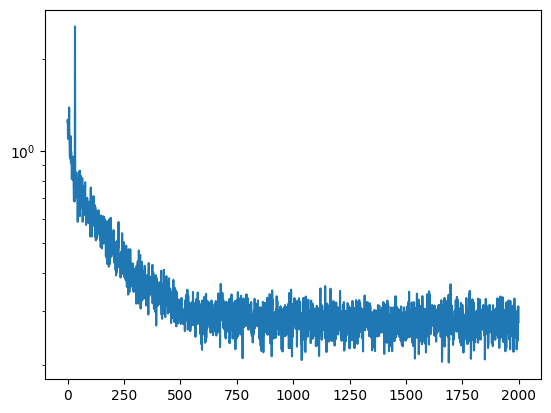

In [15]:
data_batch_size=100
pre_trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=2000,
    horizon_length=5,
    data_gen_sin=dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))

policy_pre,fin_opt_state,fin_keys,losses, val_losses=pre_trainer.fit_on_node(policy, node, motor_env.tau, featurize_node, keys, opt_state)
plt.plot(losses)
plt.yscale('log')

100%|██████████| 10000/10000 [04:42<00:00, 35.39it/s]


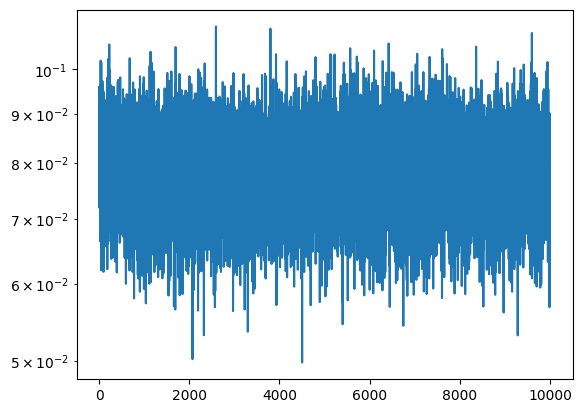

In [16]:
fin_policy_1,fin_opt_state,fin_keys,losses, val_losses=trainer.fit_on_node(policy_pre, node, motor_env.tau, featurize_node, keys, opt_state)
plt.plot(losses)
plt.yscale('log')

### 2.Example: DPC Training on pmsm_env

In [17]:
fin_policy_env,fin_opt_state2,fin_keys2,losses2 ,val_losses2=trainer.fit_on_env(policy,motor_env,keys,opt_state)
plt.plot(losses2)
plt.yscale('log')

  0%|          | 0/10000 [00:00<?, ?it/s]

  1%|          | 99/10000 [00:18<31:32,  5.23it/s]  


KeyboardInterrupt: 

## Evaluate on pmsm_env (motor_env):

In [18]:
from utils.evaluation import steps_eval

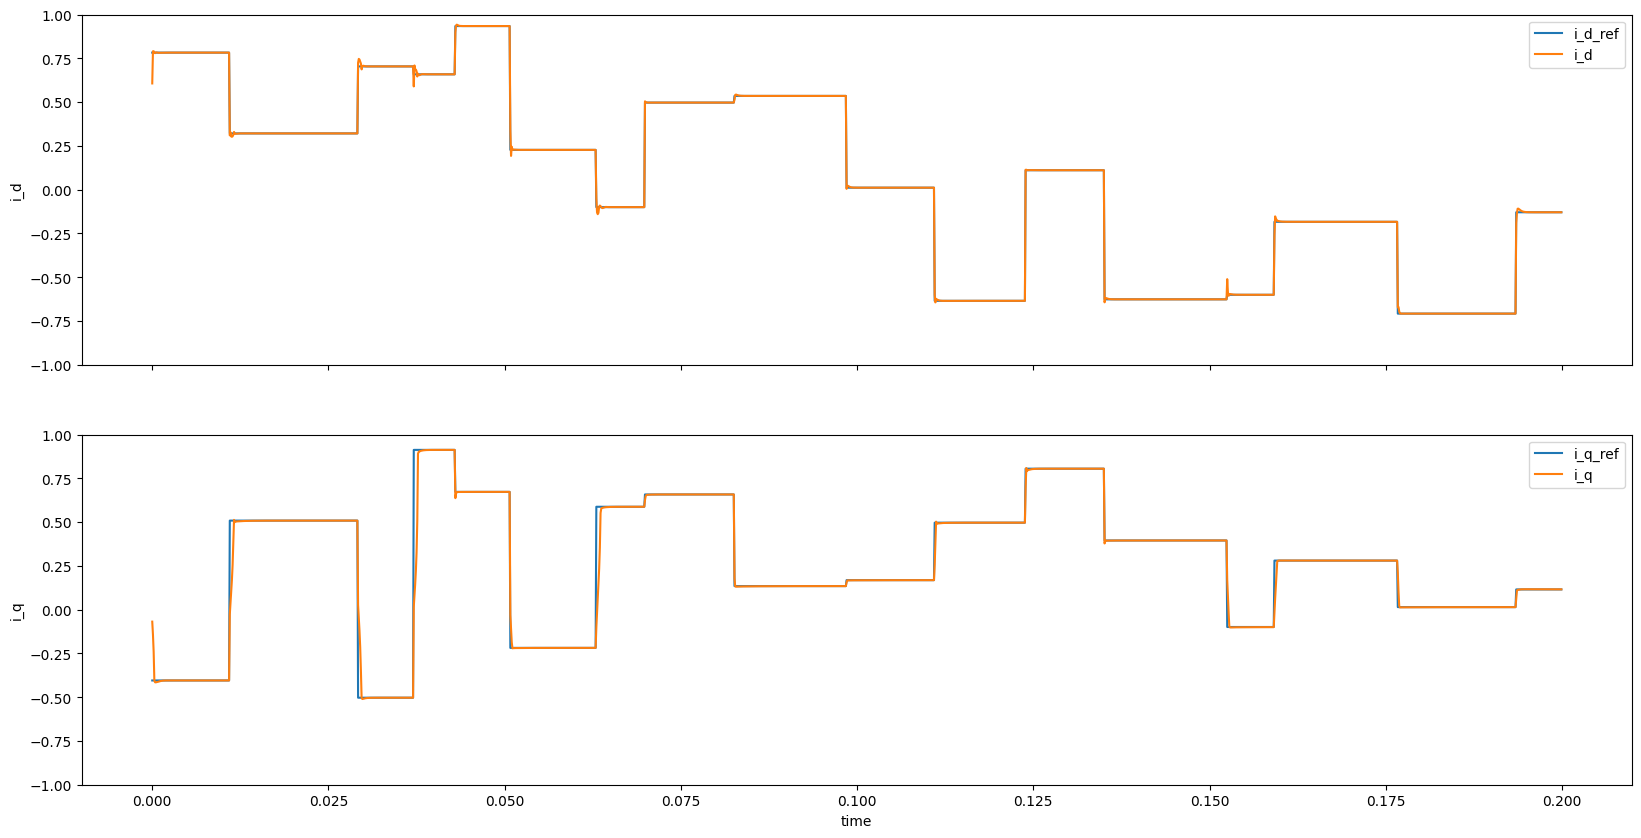

In [19]:
obs,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_1,featurize,jax.random.PRNGKey(2),2000)

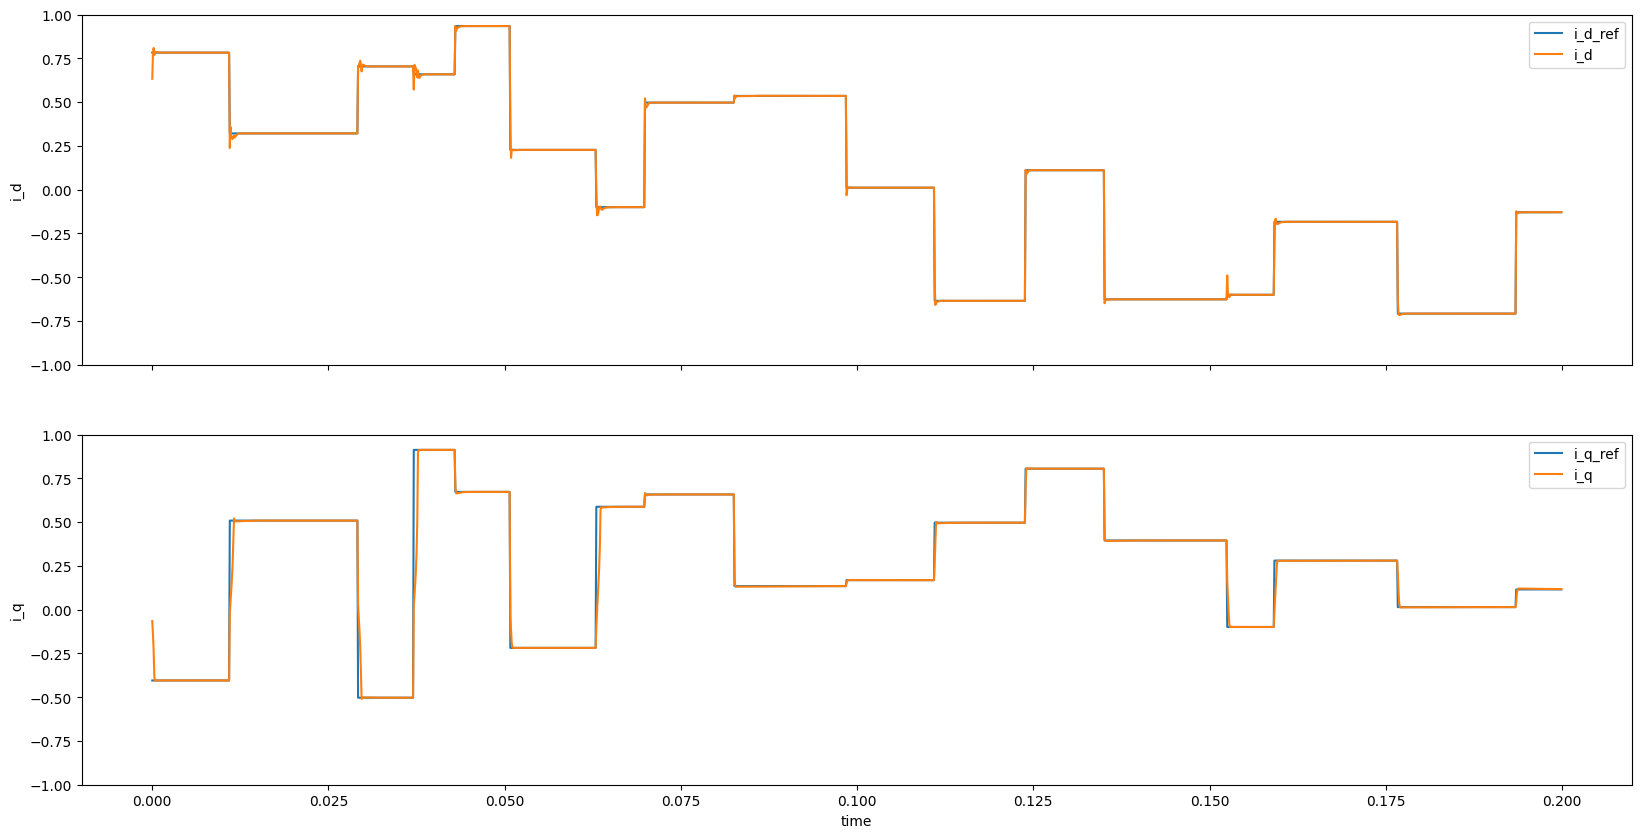

In [ ]:
obs,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_env,featurize,jax.random.PRNGKey(2),2000)